# Modified Unet Use

Uses the trained Unet on new data -> unet_trained.pth

Input -> T1w_11.nii

Output -> segmented_T1w_11.nii



In [1]:
import torch
import torch.nn as nn
import nibabel as nib
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# ------------------------------------------------
# SAME MODEL AS TRAINING
# ------------------------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),

            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.net(x)

class UNet3D(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = DoubleConv(1, 32)
        self.p1 = nn.MaxPool3d(2)

        self.d2 = DoubleConv(32, 64)
        self.p2 = nn.MaxPool3d(2)

        self.d3 = DoubleConv(64, 128)

        self.u2 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.db2 = DoubleConv(128, 64)

        self.u1 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.db1 = DoubleConv(64, 32)

        self.final = nn.Conv3d(32, 1, kernel_size=1)

    def forward(self, x):
        c1 = self.d1(x)
        p1 = self.p1(c1)

        c2 = self.d2(p1)
        p2 = self.p2(c2)

        bottleneck = self.d3(p2)

        u2 = self.u2(bottleneck)
        merge2 = torch.cat([u2, c2], dim=1)
        c2d = self.db2(merge2)

        u1 = self.u1(c2d)
        merge1 = torch.cat([u1, c1], dim=1)
        c1d = self.db1(merge1)

        return torch.sigmoid(self.final(c1d))   # sigmoid for binary output


# ------------------------------------------------
# LOAD TRAINED MODEL
# ------------------------------------------------
model = UNet3D().to(device)

state = torch.load("unet_trained.pth", map_location=device)
model.load_state_dict(state)
model.eval()

print("✅ Model loaded successfully")


# ------------------------------------------------
# LOAD NEW 4D FILE (T1w_11.nii)
# ------------------------------------------------
img_nii = nib.load("T1w_11.nii")
img = img_nii.get_fdata()   # shape (X,Y,Z,T)

print("Loaded MRI shape:", img.shape)

# Normalize
img = (img - np.mean(img)) / (np.std(img) + 1e-8)

# Convert to torch: (T,1,X,Y,Z)
img_t = torch.tensor(img, dtype=torch.float32)
img_t = img_t.permute(3,0,1,2).unsqueeze(1).to(device)


# ------------------------------------------------
# RUN INFERENCE ACROSS TIMEPOINTS
# ------------------------------------------------
preds = []

with torch.no_grad():
    for t in range(img_t.shape[0]):
        vol = img_t[t:t+1]  # shape (1,1,X,Y,Z)
        out = model(vol)
        out = (out > 0.5).float()  # binarize
        preds.append(out.cpu().numpy()[0,0])

# Convert list → 4D volume: (X,Y,Z,T)
pred_4d = np.stack(preds, axis=-1)

# ------------------------------------------------
# SAVE AS NIFTI
# ------------------------------------------------
seg_nii = nib.Nifti1Image(pred_4d.astype(np.uint8), img_nii.affine)
nib.save(seg_nii, "segmented_T1w_11.nii")

print("🎉 Saved segmentation: segmented_T1w_11.nii")

Using: cuda
✅ Model loaded successfully
Loaded MRI shape: (192, 192, 60, 5)
🎉 Saved segmentation: segmented_T1w_11.nii


# Visualization

Loaded NIfTI file: segmented_T1w_11.nii
Data shape: (192, 192, 60, 5)

=== SUMMARY STATISTICS FOR 5 VOLUMES ===
Total original components: 11
Total original voxels: 294098.0
Total cleaned voxels: 293936
Overall reduction: 0.1%
Average components per volume: 2.2
Average reduction per volume: 0.1%


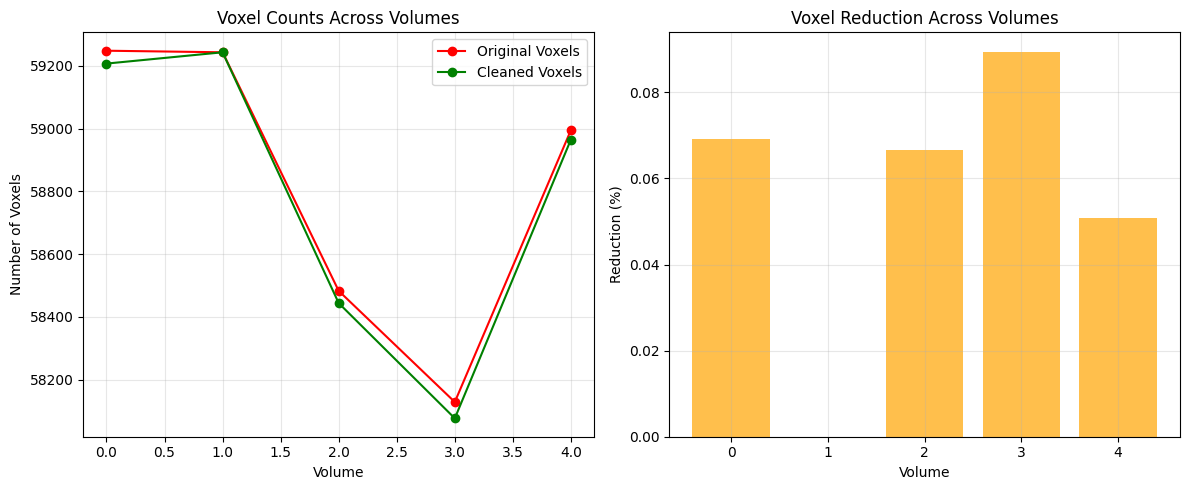

Save cleaned mask? (y/n):  n



✅ Processing completed. Variables available:
  - cleaned_mask_4d: 4D cleaned mask
  - input_mask: original 4D data
  - volume_stats: per-volume statistics


In [4]:
# =============================================================================
# IMPORTS
# =============================================================================
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label

# =============================================================================
# LOAD 4D NIFTI FILE
# =============================================================================
file_path = "segmented_T1w_11.nii"
nii = nib.load(file_path)
input_mask = nii.get_fdata()  # 4D: (X, Y, Z, T)
input_affine = nii.affine
print(f"Loaded NIfTI file: {file_path}")
print(f"Data shape: {input_mask.shape}")

# =============================================================================
# FUNCTION TO EXTRACT LARGEST COMPONENT
# =============================================================================
def extract_largest_component(volume):
    labeled, num_features = label(volume)
    if num_features == 0:
        return np.zeros_like(volume), 0
    # Find the largest component
    sizes = np.bincount(labeled.flat)
    sizes[0] = 0  # Ignore background
    largest_label = sizes.argmax()
    cleaned = (labeled == largest_label).astype(np.uint8)
    return cleaned, num_features

# =============================================================================
# PROCESS EACH VOLUME
# =============================================================================
T = input_mask.shape[3]
cleaned_mask_4d = np.zeros_like(input_mask, dtype=np.uint8)
volume_stats = []

for t in range(T):
    vol = input_mask[:, :, :, t]
    cleaned, num_components = extract_largest_component(vol)
    cleaned_mask_4d[:, :, :, t] = cleaned
    
    original_voxels = np.sum(vol)
    cleaned_voxels = np.sum(cleaned)
    reduction_percent = ((original_voxels - cleaned_voxels) / original_voxels * 100) if original_voxels > 0 else 0
    largest_component_size = np.max(np.bincount(label(vol)[0].flat)) if original_voxels > 0 else 0
    
    volume_stats.append({
        "volume_index": t,
        "original_components": num_components,
        "original_voxels": original_voxels,
        "cleaned_voxels": cleaned_voxels,
        "reduction_percent": reduction_percent,
        "largest_component_size": largest_component_size
    })

# =============================================================================
# DISPLAY STATISTICS AND VISUALIZATIONS
# =============================================================================
total_original_components = sum(stat['original_components'] for stat in volume_stats)
total_original_voxels = sum(stat['original_voxels'] for stat in volume_stats)
total_cleaned_voxels = sum(stat['cleaned_voxels'] for stat in volume_stats)
overall_reduction = ((total_original_voxels - total_cleaned_voxels) / total_original_voxels * 100) if total_original_voxels > 0 else 0

print(f"\n=== SUMMARY STATISTICS FOR {T} VOLUMES ===")
print(f"Total original components: {total_original_components}")
print(f"Total original voxels: {total_original_voxels}")
print(f"Total cleaned voxels: {total_cleaned_voxels}")
print(f"Overall reduction: {overall_reduction:.1f}%")
print(f"Average components per volume: {total_original_components/T:.1f}")
print(f"Average reduction per volume: {np.mean([stat['reduction_percent'] for stat in volume_stats]):.1f}%")

# Plot voxel counts and reduction
plt.figure(figsize=(12, 5))

# Original vs Cleaned voxels
plt.subplot(1, 2, 1)
original_voxels = [stat['original_voxels'] for stat in volume_stats]
cleaned_voxels = [stat['cleaned_voxels'] for stat in volume_stats]
plt.plot(range(T), original_voxels, 'ro-', label='Original Voxels')
plt.plot(range(T), cleaned_voxels, 'go-', label='Cleaned Voxels')
plt.xlabel('Volume')
plt.ylabel('Number of Voxels')
plt.title('Voxel Counts Across Volumes')
plt.legend()
plt.grid(True, alpha=0.3)

# Reduction %
plt.subplot(1, 2, 2)
reduction_percentages = [stat['reduction_percent'] for stat in volume_stats]
plt.bar(range(T), reduction_percentages, color='orange', alpha=0.7)
plt.xlabel('Volume')
plt.ylabel('Reduction (%)')
plt.title('Voxel Reduction Across Volumes')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# OPTIONAL: SAVE CLEANED MASK
# =============================================================================
save_cleaned = input("Save cleaned mask? (y/n): ").lower().strip()
if save_cleaned == 'y':
    cleaned_filename = input("Enter filename (e.g., cleaned_segmentation.nii): ").strip()
    if not cleaned_filename:
        cleaned_filename = "cleaned_segmentation.nii"
    cleaned_nifti = nib.Nifti1Image(cleaned_mask_4d, input_affine)
    nib.save(cleaned_nifti, cleaned_filename)
    print(f"Saved cleaned mask as {cleaned_filename}")

print("\n✅ Processing completed. Variables available:")
print("  - cleaned_mask_4d: 4D cleaned mask")
print("  - input_mask: original 4D data")
print("  - volume_stats: per-volume statistics")


Data shape: (192, 192, 60, 5)


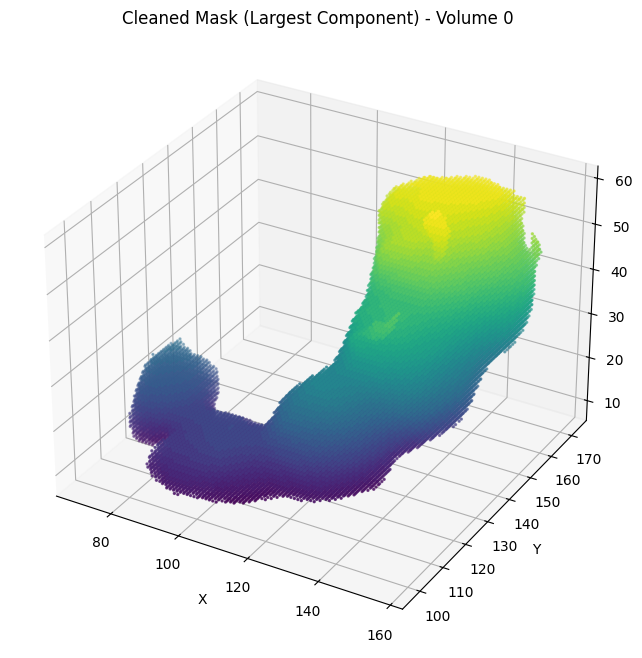

In [5]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label
from mpl_toolkits.mplot3d import Axes3D

# Load NIfTI file
file_path = "segmented_T1w_11.nii"
nii = nib.load(file_path)
data = nii.get_fdata()
print("Data shape:", data.shape)

# Choose a volume index to visualize
t_index = 0
volume = data[:, :, :, t_index]

# Extract largest component
labeled, num_features = label(volume)
sizes = np.bincount(labeled.flat)
sizes[0] = 0  # ignore background
largest_label = sizes.argmax()
largest_component = (labeled == largest_label).astype(np.uint8)

# Get coordinates of the component
coords = np.array(np.nonzero(largest_component))

# 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[0], coords[1], coords[2], c=coords[2], cmap='viridis', marker='o', s=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Cleaned Mask (Largest Component) - Volume {t_index}')
plt.show()